## Import all Modules

In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split


Check if Cuda is available:

In [2]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 639.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.5/783.5 kB 5.5 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


## Setting up the dataset paths

In [5]:
dataset_path = '/kaggle/input/car-plate-detection'

In [6]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.
    
    Parameters:
    filename(str): The input string to search for digits.
    
    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurance of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0
    
# Example usage
print(the_number_in_the_string('file123.txt')) # Output: 123
print(the_number_in_the_string('no_numbers_here'))# Output: 0


123
0


## Formatting the XML File and creating DF

In [7]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob

# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path = [],
    xmin = [],
    xmax = [],
    ymin = [],
    ymax = [],
    img_w = [],
    img_h = []
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by thr numerical value in the filenames
for filename in sorted(xml_files, key = the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filname and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
    
    # Append the extracted information to thr respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size = 1/10, random_state = 42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in 80/10/10 split overall
train, val = train_test_split(train, train_size = 8/9, random_state = 42)

# Print the number of samples in each set
print(f'''
    len(train) = {len(train)}
    len(val) = {len(val)}
    len(test) = {len(test)}
''')


    len(train) = 345
    len(val) = 44
    len(test) = 44



In [9]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')
    

In [10]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/kaggle/input/car-plate-detection/images/Cars1...,305,320,256,267,400,267
315,/kaggle/input/car-plate-detection/images/Cars3...,12,385,98,181,400,300
282,/kaggle/input/car-plate-detection/images/Cars2...,37,319,145,203,350,263
236,/kaggle/input/car-plate-detection/images/Cars2...,223,250,106,119,400,176
112,/kaggle/input/car-plate-detection/images/Cars1...,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/kaggle/input/car-plate-detection/images/Cars1...,286,328,133,159,400,267
255,/kaggle/input/car-plate-detection/images/Cars2...,116,273,156,188,400,267
292,/kaggle/input/car-plate-detection/images/Cars2...,91,137,187,208,400,267
54,/kaggle/input/car-plate-detection/images/Cars5...,148,257,61,118,400,300


In [11]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.
    
    Parameters:
    split_name (str): The name of the split (e.g., 'tarin', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data foe the split.
    
    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')
    
    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']
        
        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
        
    print(f"Created '{images_path}' and '{labels_path}'")

In [12]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format('train', train)
make_split_folder_in_yolo_format('val', val)
make_split_folder_in_yolo_format('test', test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [13]:
os.getcwd()

'/kaggle/working'

In [14]:
!pip install opencv-python

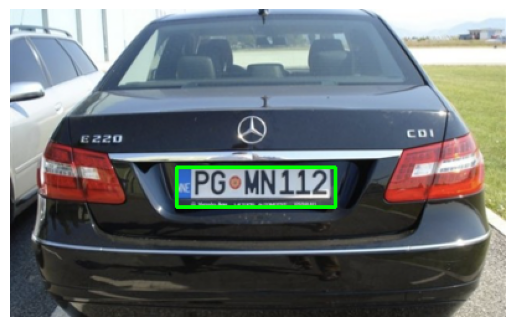

In [15]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get boundng box information
with open(label_path, 'r') as f:
    lines = f.readlines()
    
# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape
    
    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    
    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    
    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image


Making .yaml File

In [16]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new 

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yalm file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)
    

In [17]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 71.1MB/s]


In [18]:
model.train(
    data = 'datasets.yaml',  # Path to the dataset configuration file
    epochs = 130,            # Number of training epochs
    batch = 16,              # Batch size
    device = 'cuda',         # Use GPU for Training
    imgsz = 320,             # Image size (width and height) for training
    cache = True
)

Ultralytics YOLOv8.2.36 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=130, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 14.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 465.18it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 185.91it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 475.03it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 154.06it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 130 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/130     0.908G      1.803      3.007       1.36         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         44         44    0.00401      0.932      0.502      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/130     0.849G      1.489      1.512      1.141         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         44         44          1      0.115      0.307      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/130     0.858G      1.524       1.36      1.185         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]

                   all         44         44      0.423      0.159      0.219     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/130     0.872G      1.469      1.272      1.202         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         44         44          1      0.129      0.294      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/130     0.872G      1.476       1.25      1.197         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         44         44      0.723      0.318      0.399      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/130     0.872G      1.449       1.14      1.183         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.655      0.455      0.554      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/130     0.864G      1.471      1.111       1.22         10        320: 100%|██████████| 22/22 [00:02<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]

                   all         44         44      0.806      0.773      0.758      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/130     0.872G       1.42      1.025      1.172         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         44         44       0.83      0.774      0.795      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/130     0.866G      1.406      1.033      1.179         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


                   all         44         44      0.853      0.864      0.863      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/130     0.872G      1.367     0.9598      1.186         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         44         44      0.885      0.773      0.848      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/130     0.866G      1.395     0.9899      1.172         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

                   all         44         44      0.784      0.773      0.769      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/130     0.872G      1.393     0.9659      1.195         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]

                   all         44         44      0.916      0.773      0.875      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/130     0.866G      1.377     0.9316      1.175         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         44         44      0.893      0.818      0.899      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/130     0.872G      1.303     0.8832      1.118         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]

                   all         44         44      0.939      0.864      0.906      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/130     0.866G       1.28      0.866      1.106         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         44         44      0.889      0.795      0.864      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/130     0.872G       1.29     0.8623      1.099         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


                   all         44         44      0.898      0.802      0.848       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/130     0.866G      1.301     0.8289      1.108         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         44         44      0.862      0.849      0.884      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/130     0.872G      1.362     0.8856      1.136         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]

                   all         44         44      0.924      0.841      0.846      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/130     0.866G      1.284     0.8366      1.107         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         44         44      0.949      0.841      0.876      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/130     0.872G      1.218     0.7932      1.113         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


                   all         44         44      0.922      0.864      0.924        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/130     0.864G       1.22     0.8149      1.096         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]

                   all         44         44      0.854      0.841      0.871      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/130     0.872G      1.237     0.7758      1.082         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         44         44      0.904      0.857      0.872      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/130     0.866G      1.149       0.74      1.065         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

                   all         44         44       0.82      0.864      0.894      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/130     0.872G      1.193     0.7432      1.063         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

                   all         44         44      0.878      0.821      0.837      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/130     0.866G      1.147     0.7406      1.052         25        320: 100%|██████████| 22/22 [00:01<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]

                   all         44         44      0.913      0.841      0.882      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/130     0.872G      1.191     0.7484      1.078         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         44         44      0.867      0.909      0.867      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/130     0.864G      1.182      0.755      1.052         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


                   all         44         44      0.919      0.841      0.914      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/130     0.872G      1.148     0.7461      1.056         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]

                   all         44         44      0.881      0.886      0.881      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/130     0.866G      1.183     0.7406      1.081         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         44         44       0.81      0.886      0.853      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/130     0.872G      1.161     0.7582      1.044         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         44         44      0.845      0.795      0.834      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/130     0.864G      1.163     0.7244      1.072         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         44         44      0.868      0.818      0.827      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/130     0.872G       1.19      0.727      1.058         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


                   all         44         44      0.881      0.841      0.879      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/130     0.866G      1.111     0.6944      1.054         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]

                   all         44         44      0.926      0.851      0.884      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/130     0.872G      1.118     0.6745      1.053         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]


                   all         44         44      0.875      0.795      0.896      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/130     0.866G      1.086     0.6573      1.026         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         44         44      0.828      0.909      0.923      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/130     0.872G       1.13     0.6679      1.038         15        320: 100%|██████████| 22/22 [00:02<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.60it/s]

                   all         44         44      0.904      0.859      0.897      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/130     0.866G      1.121     0.6657      1.041         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


                   all         44         44      0.973      0.825      0.936      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/130     0.872G       1.07     0.6606      1.013         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


                   all         44         44      0.862      0.886      0.925      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/130     0.864G       1.12     0.6713      1.048         10        320: 100%|██████████| 22/22 [00:01<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         44         44      0.867      0.887      0.914      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/130     0.872G      1.031     0.6602      1.004         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


                   all         44         44      0.854      0.864      0.878      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/130     0.864G      1.086     0.6726      1.012         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         44         44       0.89      0.886       0.89      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/130     0.872G      1.041     0.6381     0.9946         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]

                   all         44         44      0.936      0.841       0.88      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/130     0.866G       1.02     0.6297      1.016         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         44         44      0.884      0.841      0.886      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/130     0.872G      1.053     0.6458      1.014         11        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]

                   all         44         44      0.921      0.818      0.904      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/130     0.866G      1.031     0.6036     0.9985         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

                   all         44         44      0.851      0.906      0.913       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/130     0.872G      1.017     0.6124     0.9941         16        320: 100%|██████████| 22/22 [00:02<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]

                   all         44         44      0.974      0.839      0.936       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/130     0.866G      1.021     0.6394      1.005         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.921      0.864      0.926      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/130     0.872G      1.028     0.6146      1.006         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

                   all         44         44      0.918      0.841      0.928      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/130     0.866G      1.073     0.6348      1.022         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         44         44      0.794      0.877        0.9      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/130     0.872G       1.02     0.6051      1.007         24        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44      0.829      0.886      0.901      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/130     0.864G      1.013     0.6181      0.986         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

                   all         44         44      0.883      0.864       0.89      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/130     0.872G     0.9659     0.5898     0.9823         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


                   all         44         44      0.868      0.909      0.922      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/130     0.866G     0.9705      0.574     0.9778         11        320: 100%|██████████| 22/22 [00:01<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         44         44       0.84      0.886      0.908      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/130      0.87G     0.9976     0.5965     0.9629         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]

                   all         44         44      0.937      0.864        0.9      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/130     0.864G      1.017     0.6134     0.9994         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         44         44      0.937      0.795      0.872      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/130     0.872G     0.9795      0.587     0.9888         18        320: 100%|██████████| 22/22 [00:02<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         44         44      0.832      0.903      0.899      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/130     0.866G     0.9796     0.6025          1         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         44         44      0.877      0.909      0.928      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/130     0.872G     0.9286     0.5756      0.983         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         44         44      0.792      0.864      0.898      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/130     0.866G     0.9869     0.5828     0.9786         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         44         44      0.924      0.828      0.902      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/130     0.872G     0.9375     0.5733     0.9811         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

                   all         44         44      0.881      0.909      0.915      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/130     0.866G      0.935     0.5711     0.9838         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]

                   all         44         44      0.893      0.886      0.912      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/130      0.87G     0.9156     0.5523     0.9669         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         44         44      0.913      0.909      0.903      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/130     0.866G     0.9448      0.566     0.9717         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]

                   all         44         44      0.915      0.864      0.895      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/130     0.872G     0.9143     0.5685     0.9771         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]

                   all         44         44      0.885      0.877      0.889      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/130     0.864G     0.9537     0.5772     0.9796         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         44         44      0.869      0.905      0.894      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/130     0.872G     0.9521     0.5689     0.9951         15        320: 100%|██████████| 22/22 [00:02<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.829      0.864      0.903      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/130     0.866G      0.908     0.5391     0.9623         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         44         44      0.847      0.882      0.892      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/130     0.872G     0.8854      0.548     0.9722         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         44         44       0.85        0.9        0.9      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/130     0.866G     0.9106     0.5397     0.9618         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]

                   all         44         44      0.949      0.795      0.909      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/130     0.872G     0.9325     0.5506     0.9812         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44      0.823      0.955      0.937      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/130     0.866G     0.8879     0.5324     0.9472         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

                   all         44         44       0.88      0.886      0.905      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/130     0.872G     0.9181     0.5423     0.9736         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         44         44      0.886      0.885      0.907      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/130     0.866G     0.8952     0.5452      0.967         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         44         44      0.881      0.886      0.903      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/130     0.872G     0.9177      0.549     0.9527         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]

                   all         44         44      0.856      0.955      0.946      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/130     0.866G     0.8687     0.5144     0.9401         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]

                   all         44         44      0.862      0.886       0.92      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/130     0.872G     0.8549     0.5228     0.9442         21        320: 100%|██████████| 22/22 [00:02<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


                   all         44         44      0.885      0.909      0.938      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/130     0.866G     0.8472     0.5031     0.9371         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]

                   all         44         44      0.871      0.955      0.954      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/130     0.872G     0.8511     0.5081     0.9461         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         44         44       0.87      0.932      0.933      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/130     0.866G     0.8476     0.5111      0.956         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44       0.82       0.93      0.916      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/130     0.872G     0.8262     0.5056      0.916         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44      0.886      0.885       0.91      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/130     0.866G     0.8414      0.513     0.9495         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         44         44      0.884      0.864      0.916      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/130     0.872G      0.875     0.5163      0.949         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

                   all         44         44      0.886      0.909      0.922      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/130     0.864G     0.8301     0.5068     0.9359         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


                   all         44         44      0.883      0.886      0.912      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/130     0.872G     0.8247     0.4953     0.9213         24        320: 100%|██████████| 22/22 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         44         44      0.879      0.886       0.91      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/130     0.866G     0.8339     0.4808     0.9415         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


                   all         44         44      0.865      0.878       0.91      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/130     0.872G     0.8171     0.4834     0.9443         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


                   all         44         44      0.862      0.864      0.893      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/130     0.864G      0.813      0.485     0.9364         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         44         44      0.879      0.864      0.922      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/130     0.872G     0.8167     0.4819      0.937         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.879      0.829      0.875      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/130     0.866G     0.8528     0.5025     0.9317         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.879      0.886      0.902      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/130      0.87G     0.7928     0.4617     0.9318         10        320: 100%|██████████| 22/22 [00:01<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


                   all         44         44      0.901      0.886      0.916      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/130     0.866G     0.8029     0.4915     0.9335         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]

                   all         44         44      0.898      0.909       0.93      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/130     0.872G     0.7883     0.4663     0.9369         24        320: 100%|██████████| 22/22 [00:01<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

                   all         44         44      0.863      0.864      0.892      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/130     0.866G     0.8264     0.4831     0.9566         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]

                   all         44         44      0.859      0.886      0.885      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/130      0.87G     0.7864     0.4768     0.9199         12        320: 100%|██████████| 22/22 [00:02<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all         44         44      0.848      0.886      0.889      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/130     0.864G     0.7906     0.4705     0.9278         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

                   all         44         44      0.866      0.886      0.899      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/130     0.872G     0.7666     0.4738     0.9362         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         44         44      0.838      0.864      0.887      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/130     0.866G     0.8042     0.4804     0.9319         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         44         44      0.862      0.886      0.902      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/130     0.872G     0.7713     0.4732     0.9245         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44      0.864      0.864      0.898      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/130     0.866G      0.732     0.4578      0.924         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

                   all         44         44      0.844      0.861      0.879      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/130     0.872G      0.753     0.4624     0.9159         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

                   all         44         44      0.864      0.886      0.907      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/130     0.866G     0.7409     0.4456      0.917         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]

                   all         44         44      0.844      0.886      0.907      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/130     0.872G     0.7797     0.4682     0.9288         11        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         44         44      0.862      0.886      0.916      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/130     0.866G      0.768     0.4512     0.9127         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         44         44      0.806      0.886      0.901      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/130     0.872G     0.7626     0.4448      0.925         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         44         44      0.808      0.862      0.876      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/130     0.866G     0.7384     0.4345      0.916         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]

                   all         44         44      0.814      0.864      0.884        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/130     0.872G     0.7252     0.4372      0.905         18        320: 100%|██████████| 22/22 [00:02<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

                   all         44         44       0.85      0.909      0.896       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/130     0.866G     0.7419       0.44     0.9084         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


                   all         44         44      0.832      0.902      0.897      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/130     0.872G     0.7675     0.4523     0.9266         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

                   all         44         44      0.815      0.903      0.892      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/130     0.864G     0.7411     0.4433     0.9242         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.838      0.822       0.88      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/130     0.872G     0.7316     0.4365     0.9243         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]


                   all         44         44      0.789      0.864      0.879      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/130     0.866G     0.7248     0.4298     0.9049         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

                   all         44         44      0.853      0.864      0.893      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/130     0.872G      0.713     0.4257     0.9119         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         44         44       0.86      0.864      0.893      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/130     0.866G     0.6987     0.4123     0.9161         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         44         44      0.902      0.886      0.914      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/130     0.872G     0.7348      0.431     0.9152         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44       0.88      0.886      0.911      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/130     0.864G     0.7168     0.4355     0.9042         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]

                   all         44         44      0.848      0.909      0.922      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/130     0.872G     0.7175     0.4249     0.9074         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


                   all         44         44      0.833      0.908      0.897      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/130     0.864G     0.6973     0.4305     0.9133         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         44         44      0.849      0.909      0.917      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/130     0.872G     0.6921     0.4082      0.903         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]


                   all         44         44      0.866      0.909      0.913       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/130     0.866G     0.7096      0.426     0.9035         16        320: 100%|██████████| 22/22 [00:02<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         44         44      0.848      0.909      0.913      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/130     0.872G     0.6683     0.4038     0.9085         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44       0.85      0.905       0.91      0.525


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/130     0.864G     0.9468     0.5053      1.031          8        320: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         44         44      0.863      0.886      0.895      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/130     0.872G     0.9037     0.4838      1.006          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44      0.861      0.886      0.885      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/130     0.864G     0.9274     0.4702     0.9815          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         44         44      0.833      0.905        0.9      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/130      0.87G     0.9217     0.4775      1.001          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]

                   all         44         44      0.833      0.906      0.901      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/130     0.864G     0.8769     0.4587     0.9756          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.833      0.904      0.905      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/130      0.87G     0.8855     0.4706     0.9978          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

                   all         44         44      0.866       0.88      0.911      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/130     0.864G     0.8704     0.4515      0.985          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]

                   all         44         44      0.864      0.886      0.911      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/130      0.87G     0.8704     0.4492     0.9935          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.855      0.886       0.91       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/130     0.864G     0.8799     0.4465     0.9797          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


                   all         44         44      0.851      0.886      0.909      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/130      0.87G     0.8717     0.4538     0.9689          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]

                   all         44         44      0.847      0.886      0.908      0.544



130 epochs completed in 0.117 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.36 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


                   all         44         44      0.973      0.824      0.936      0.557
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▄▇███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▄▇███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▄▇███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▆▇█▇█▇▇▇▇█▇███▇▇█▇██████▇█▇▇██▇▇▇▇█▇██
metrics/mAP50-95(B),▁▁▅▇▇▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
metrics/precision(B),██▂▄▆▅▅▄▄▃▄▃▃▅▇▂▆▂▄▄▂▂▃▄▄▄▃▅▃▃▄▃▃▁▃▂▃▃▄▇
metrics/recall(B),▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███▇▇▇▇▇▇▇▇█▇▇██▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇▇▆▇▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▃▃▃


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bae960304f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

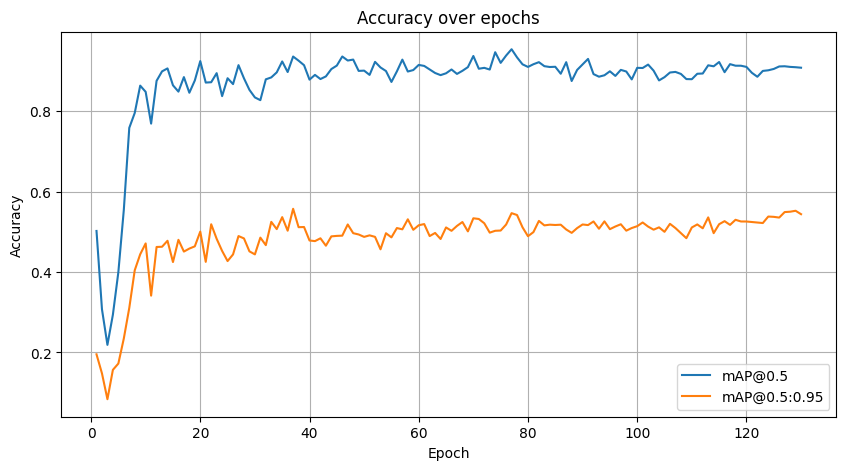

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key = the_number_in_the_string)\

# Load the training results from CSV file 
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading / trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1 # Epochs are zero-indexed, so added 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU = 0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU = 0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(epochs, mAP_0_5, label = 'mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label = 'mAP@0.5:0.95')
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [22]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 48.3ms
Speed: 0.7ms preprocess, 48.3ms inference, 8.2ms postprocess per image at shape (1, 3, 160, 320)


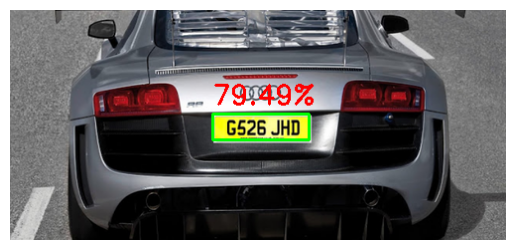

In [23]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 47.0ms
Speed: 0.8ms preprocess, 47.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)


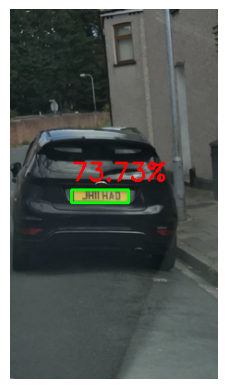

In [24]:
predict_and_plot(test.iloc[2].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars287.png: 288x320 1 license_plate, 52.5ms
Speed: 1.1ms preprocess, 52.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 320)


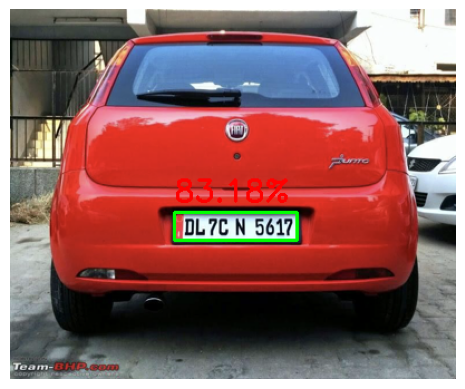

In [25]:
predict_and_plot(test.iloc[20].img_path)

## Implementing Text Extraction

In [26]:
!pip install pytesseract

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 38.5ms
Speed: 1.3ms preprocess, 38.5ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 320)
Detected text: G526 JHD



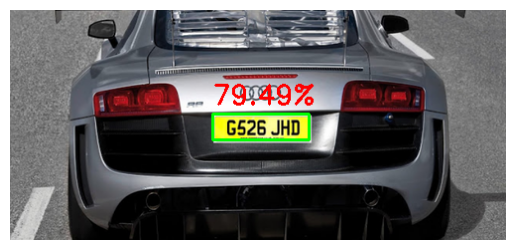

In [28]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 39.5ms
Speed: 1.2ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 192)
Detected text: | JHUHAD |



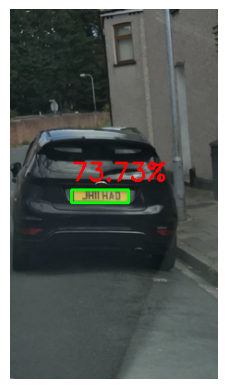

In [29]:
predict_and_plot(test.iloc[2].img_path)

In [1]:
predict_and_plot(test.iloc[40].img_path)

NameError: name 'predict_and_plot' is not defined